##Loading Libraries

In [1]:
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm

print(tf.__version__)

2.8.2


#Load Dataset

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4431872/4422102 [==============================] - 0s 0us/step

Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


##Reshape data

In [3]:
# reshape for feeding into the model
train_images_gr = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images_gr = test_images.reshape(test_images.shape[0], 28, 28, 1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_gr.shape, train_images_gr.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_gr.shape, test_images_gr.dtype))


Train_images.shape: (60000, 28, 28, 1), of uint8
Test_images.shape: (10000, 28, 28, 1), of uint8


#Visualize data

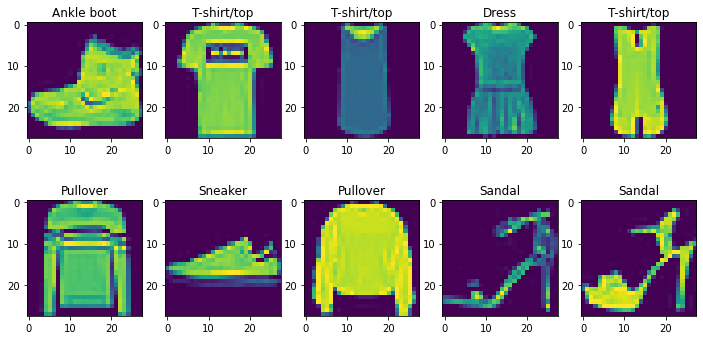

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
c = 0
for i in range(10):
  idx = i // 5
  idy = i % 5
  ax[idx, idy].imshow(train_images_gr[i].reshape(28,28))
  ax[idx, idy].set_title(class_names[train_labels[i]])

#Building CNN

##To sum up, 'valid' padding means no padding. The output size of the convolutional layer shrinks depending on the input size & kernel size. On the contrary, 'same' padding means using padding.

In [7]:
# define input shape
INPUT_SHAPE = (28, 28, 1)

# define sequential model
model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),
activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# define conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),
activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 256)               2

#Model Training

In [8]:
EPOCHS = 100
train_images_scaled = train_images_gr / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
restore_best_weights=True,
verbose=1)

history = model.fit(train_images_scaled, train_labels,
batch_size=32,
callbacks=[es_callback],
validation_split=0.1, epochs=EPOCHS,
verbose=1)

Epoch 1/100
1688/1688 [==============================] - 41s 23ms/step - loss: 0.5573 - accuracy: 0.7907 - val_loss: 0.3621 - val_accuracy: 0.8635
Epoch 2/100
1688/1688 [==============================] - 41s 24ms/step - loss: 0.3577 - accuracy: 0.8695 - val_loss: 0.3090 - val_accuracy: 0.8880
Epoch 3/100
1688/1688 [==============================] - 38s 23ms/step - loss: 0.3066 - accuracy: 0.8887 - val_loss: 0.2926 - val_accuracy: 0.8927
Epoch 4/100
1688/1688 [==============================] - 38s 23ms/step - loss: 0.2784 - accuracy: 0.8988 - val_loss: 0.2681 - val_accuracy: 0.8983
Epoch 5/100
1688/1688 [==============================] - 39s 23ms/step - loss: 0.2550 - accuracy: 0.9064 - val_loss: 0.2624 - val_accuracy: 0.9047
Epoch 6/100
1688/1688 [==============================] - 38s 23ms/step - loss: 0.2404 - accuracy: 0.9099 - val_loss: 0.2578 - val_accuracy: 0.9087
Epoch 7/100
1688/1688 [==============================] - 38s 23ms/step - loss: 0.2256 - accuracy: 0.9153 - val_loss: 0

##Plot curves

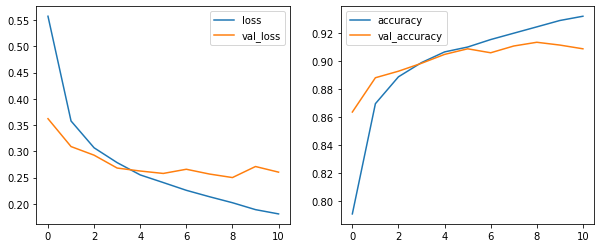

In [9]:
import pandas as pd

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

#Model Evaluation


In [10]:
test_images_scaled = test_images_gr / 255.
predictions = model.predict(test_images_scaled)
predictions[:5]

array([[9.4002717e-10, 3.6878101e-11, 4.9070742e-10, 3.3626026e-11,
        4.1476234e-10, 6.2305182e-05, 5.2994303e-10, 1.9861885e-05,
        2.2870839e-12, 9.9991786e-01],
       [5.2208026e-08, 5.3213333e-17, 9.9999487e-01, 2.0135194e-13,
        3.9170945e-06, 7.0554487e-20, 1.1423358e-06, 3.1686706e-21,
        4.8226787e-13, 7.7010159e-18],
       [1.9000423e-15, 1.0000000e+00, 8.3047478e-18, 1.7853683e-14,
        1.1965076e-19, 4.5791908e-23, 1.1593693e-16, 5.0300307e-28,
        4.9203930e-21, 8.2223419e-27],
       [7.2161781e-16, 1.0000000e+00, 3.3453120e-18, 1.7881364e-13,
        9.7318899e-18, 3.0367680e-23, 1.5977516e-15, 5.4813928e-29,
        2.1999147e-21, 1.9779441e-27],
       [7.6809786e-02, 4.1904507e-08, 1.8844560e-02, 8.0245860e-05,
        3.3645818e-04, 4.0559871e-09, 9.0392858e-01, 1.1009123e-10,
        3.4324961e-07, 4.3348025e-10]], dtype=float32)

In [11]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 6])

#Confusion Matrix

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.84      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.85      0.87      0.86      1000
       Dress       0.87      0.93      0.90      1000
        Coat       0.84      0.86      0.85      1000
      Sandal       0.97      0.98      0.98      1000
       Shirt       0.75      0.70      0.73      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.99      0.97      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,844,0,16,43,4,0,90,0,3,0
Trouser,0,978,0,15,2,0,3,0,2,0
Pullover,15,0,868,8,51,0,57,0,1,0
Dress,3,2,10,934,32,0,19,0,0,0
Coat,0,2,59,26,857,0,56,0,0,0
Sandal,1,0,0,0,0,985,0,13,0,1
Shirt,110,1,65,41,73,0,703,0,7,0
Sneaker,0,0,0,0,0,14,0,969,0,17
Bag,3,0,5,4,3,6,4,3,972,0
Ankle boot,0,0,0,0,0,9,0,35,0,956


In [13]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


#Activation Map

In [14]:
test_image_idxs = [0, 23, 28]
test_labels[test_image_idxs]

array([9, 9, 9], dtype=uint8)

In [15]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

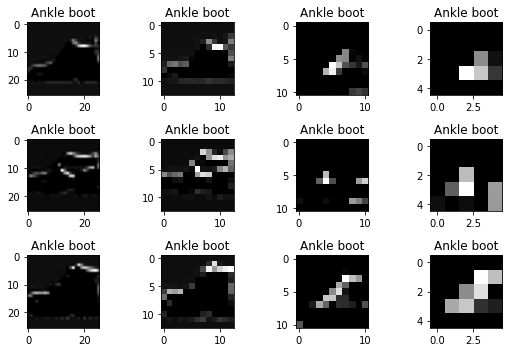

In [17]:
f, axarr = plt.subplots(3,4, figsize=(8, 5))

FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=28
CONVOLUTION_NUMBER = 13

for x in range(0,4):
    f1 = activation_model.predict(test_images_scaled[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
    axarr[0,x].grid(False)
    axarr[0,x].set_title(class_names[test_labels[FIRST_IMAGE]])
    f2 = activation_model.predict(test_images_scaled[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
    axarr[1,x].grid(False)
    axarr[1,x].set_title(class_names[test_labels[SECOND_IMAGE]])
    f3 = activation_model.predict(test_images_scaled[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
    axarr[2,x].grid(False)
    axarr[2,x].set_title(class_names[test_labels[THIRD_IMAGE]])
    plt.tight_layout()
    #13 is a good filter for ankle boot

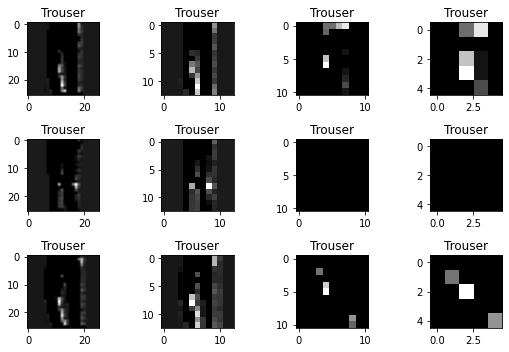

In [18]:
f, axarr = plt.subplots(3,4, figsize=(8, 5))

FIRST_IMAGE=2
SECOND_IMAGE=3
THIRD_IMAGE=5
CONVOLUTION_NUMBER = 13

for x in range(0,4):
    f1 = activation_model.predict(test_images_scaled[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
    axarr[0,x].grid(False)
    axarr[0,x].set_title(class_names[test_labels[FIRST_IMAGE]])
    f2 = activation_model.predict(test_images_scaled[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
    axarr[1,x].grid(False)
    axarr[1,x].set_title(class_names[test_labels[SECOND_IMAGE]])
    f3 = activation_model.predict(test_images_scaled[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
    axarr[2,x].grid(False)
    axarr[2,x].set_title(class_names[test_labels[THIRD_IMAGE]])
    plt.tight_layout()

  #13 is not a good filter for Trouser

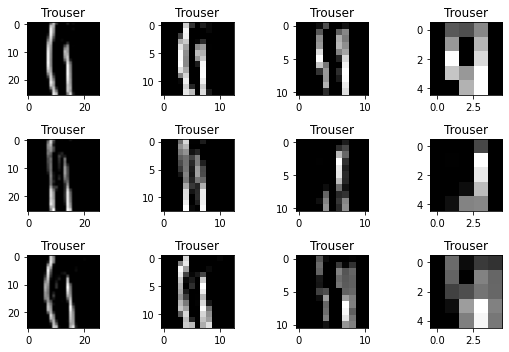

In [19]:
f, axarr = plt.subplots(3,4, figsize=(8, 5))

FIRST_IMAGE=2
SECOND_IMAGE=3
THIRD_IMAGE=5
CONVOLUTION_NUMBER = 3

for x in range(0,4):
    f1 = activation_model.predict(test_images_scaled[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
    axarr[0,x].grid(False)
    axarr[0,x].set_title(class_names[test_labels[FIRST_IMAGE]])
    f2 = activation_model.predict(test_images_scaled[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
    axarr[1,x].grid(False)
    axarr[1,x].set_title(class_names[test_labels[SECOND_IMAGE]])
    f3 = activation_model.predict(test_images_scaled[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
    axarr[2,x].grid(False)
    axarr[2,x].set_title(class_names[test_labels[THIRD_IMAGE]])
    plt.tight_layout()

#3 is a much better filter for Trouser